In [1]:
import unsloth
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 10-03 06:55:11 [__init__.py:244] Automatically detected platform cuda.


In [2]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/home/deleftheriou/cti-model-training/Qwen3-14B-Malware-Expert-r64-a128-nRO/checkpoint-340",# "unsloth/Qwen3-14B",
    max_seq_length = None,   # Context length - can be longer, but uses more memory
    load_in_4bit = False,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
)

==((====))==  Unsloth 2025.6.8: Fast Qwen3 patching. Transformers: 4.53.0. vLLM: 0.9.1.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.179 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Unsloth 2025.6.8 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [3]:
print(f"Model's context window: {model.max_seq_length}")

Model's context window: 40960


In [5]:
for name, param in model.named_parameters():
    if name in ["base_model.model.lm_head.modules_to_save.default.weight", "base_model.model.model.embed_tokens.modules_to_save.default.weight"]:
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1812725760


In [6]:
import json
import os

def load_json(path:str, filename:str):
    with open(os.path.join(path, filename), mode="r", encoding="utf-8") as f:
        return json.load(f)
    
def format_example(example:dict, system_message):
        formatted_example = [
            {"role": "assistant", "content": system_message},
            {"role": "user", "content": example["input"]},
            {"role": "assistant", "content": json.dumps(example["output"])}
        ]
        return formatted_example

In [7]:
system_messages = {

    "malware":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                 Your task is to identify all malwares referenced or implied in a CTI report. 
                 You MUST return a json with a field "objects" being a list of json objects that describe malwares.
                 To describe a malware you should provide the fields id, type, name and is_family.
                 Instead of using UUID in the id field, use the rule type--name for generating ids.
                 For example, an output in which the malware RandomMalware is identified and is not family
                 of some other malware should be like this:
                 
                 {
                     "objects": [
                         {
                             "id": "malware--RandomMalware",
                             "type": "malware",
                             "name": "RandomMalware",
                             "is_family": false
                         }
                     ]
                 }
                 
                 If no malwares are identified return a json with an empty list "objects".
                 Identify all malwares in the folowing CTI report: """, 
}

In [8]:
from unsloth.chat_templates import get_chat_template

# Example of chat template
convo = [
    {"role": "assistant", "content": "SYSTEM MESSAGE PLACEHOLDER"},
    {"role": "user", "content": "USER INPUT MESSAGE PLACEHOLDER"},
    {"role": "assistant", "content": "MODEL RESPONSE MESSAGE PLACEHOLDER"}
]

# We should add the correct chat template. No <think> and </think> should be present in the template 
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen3",
)

res = tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False)
print(f"""\nIt follows an example of a formatted instruction using chat template. If instruction_part and
response_part have been defined in config.yaml, please verify their correctness.\n\nCHAT TEMPLATE\n\n{res}""")


It follows an example of a formatted instruction using chat template. If instruction_part and
response_part have been defined in config.yaml, please verify their correctness.

CHAT TEMPLATE

<|im_start|>assistant
SYSTEM MESSAGE PLACEHOLDER<|im_end|>
<|im_start|>user
USER INPUT MESSAGE PLACEHOLDER<|im_end|>
<|im_start|>assistant
<think>

</think>

MODEL RESPONSE MESSAGE PLACEHOLDER<|im_end|>



In [9]:
from transformers import TextStreamer
import torch

text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

def format_input_prompt(system_message, user_input):
    formatted_input = [
        {"role": "assistant", "content": system_message},
        {"role": "user", "content": user_input}
    ]
    return formatted_input

def format_validation_example_for_inference(example):
    return example.split("<|im_start|>user")[1].split("<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n")[0]
                         
def inference(model, system_message, user_input, max_new_tokens=None, **kwargs):
    inputs = tokenizer.apply_chat_template(
        format_input_prompt(system_message, user_input),
        add_generation_prompt=True,
        tokenize=True,
	    return_dict=True,
        return_tensors = "pt").to(model.device)

    # Cast attention_mask to bool (recommended)
    inputs["attention_mask"] = inputs["attention_mask"].to(torch.bool)

    if not max_new_tokens:
        max_new_tokens = model.config.max_position_embeddings - inputs["input_ids"].shape[-1]
    model.generate(**inputs, streamer = text_streamer, max_new_tokens=max_new_tokens, **kwargs)

In [10]:
train_path = "/mnt/data/openCTI/splitted-io-pairs/train"
validation_path = "/mnt/data/openCTI/splitted-io-pairs/validation"

In [11]:
formatted_train_list = []
formatted_eval_list = []
include_cti_type = ["malware"]

for file in os.listdir(train_path):
    cti_type = file.split("--")[0]
    if cti_type not in include_cti_type:
        continue
    example = load_json(train_path, file)
    formatted_example = format_example(example, system_messages[cti_type])
    formatted_train_list.append(formatted_example)

for file in os.listdir(validation_path):
    cti_type = file.split("--")[0]
    if cti_type not in include_cti_type:
        continue
    example = load_json(validation_path, file)
    formatted_example = format_example(example, system_messages[cti_type])
    formatted_eval_list.append(formatted_example)

In [12]:
import datasets
from multiprocessing import cpu_count
num_proc = cpu_count()

filter_dataset = True
filter_threshold = 40960

# Add template of the model in examples
templated_train_list = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in formatted_train_list]
templated_eval_list = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in formatted_eval_list]
# Create hf seperated datasets
hf_train = datasets.Dataset.from_list([dict(text=ex) for ex in templated_train_list])
hf_eval = datasets.Dataset.from_list([dict(text=ex) for ex in templated_eval_list])
# Create a hf dataset dict
dataset = datasets.DatasetDict({"train":hf_train, "eval":hf_eval})
# Filter dataset
if filter_dataset:
    if not filter_threshold:
        filter_threshold = tokenizer.model_max_length
    dataset = dataset.filter(lambda x: len(tokenizer.encode(x["text"])) <= filter_threshold,
                             num_proc=num_proc)

Filter (num_proc=30):   0%|          | 0/1858 [00:00<?, ? examples/s]

Filter (num_proc=30):   0%|          | 0/301 [00:00<?, ? examples/s]

In [11]:
print(dataset["train"]["text"][0])

<|im_start|>assistant
You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                 Your task is to identify all malwares referenced or implied in a CTI report. 
                 You MUST return a json with a field "objects" being a list of json objects that describe malwares.
                 To describe a malware you should provide the fields id, type, name and is_family.
                 Instead of using UUID in the id field, use the rule type--name for generating ids.
                 For example, an output in which the malware RandomMalware is identified and is not family
                 of some other malware should be like this:

                 {
                     "objects": [
                         {
                             "id": "malware--RandomMalware",
                             "type": "malware",
                             "name": "RandomMalware",
                             "is_family": false
                         }
               

In [12]:
print(format_validation_example_for_inference(dataset["train"]["text"][0]))


External reference URL: https://www.fortinet.com/blog/threat-research/new-midgedropper-variant

CTI REPORT

# New MidgeDropper Variant

Affected Platforms: Windows

Impacted Users: Windows users

Impact: Potential to deploy additional malware for additional purposes

Severity Level: Medium

One of the most exciting aspects of malware analysis is coming across a family that is new or rare to the reversing community. Determining the function of the malware, who created it, and the reasons behind it become a mystery to solve. The previously unseen dropper variant we recently found, named MidgeDropper, has a complex infection chain that includes code obfuscation and sideloading, making it an interesting use case. Although we couldn’t obtain the final payload, this blog will still explore what makes this dropper tick.

## Initial Infection Vector

The initial infection vector was not available to FortiGuard Labs at the time of our investigation. However, we strongly suspect it to be a phis

In [13]:
system_message = system_messages["malware"]
user_input = format_validation_example_for_inference(dataset["train"]["text"][0])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=1000,
          temperature=0.7,
          top_p=0.8,
          top_k=20,
          min_p=0.,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

Qwen3ForCausalLM has no `_prepare_4d_causal_attention_mask_with_cache_position` method defined in its base modeling class. Compiled forward passes will be sub-optimal. If you're writing code, see Llama for an example implementation. If you're a user, please report this issue on GitHub.


<think>
Okay, let's tackle this query step by step. The user wants me to identify any malwares mentioned in the provided CTI reports and return them in a specific JSON format. 

First, I'll look at both reports given. The first one from Fortinet talks about a new Midge Dropper variant. They mention several files involved in the infection process, like "06...pdf.exe", which acts as adropper. Then there's "IC.exe", "power.exe", and "power.xml" which are part of decoding and launching "seAgent.exe". Also, "VCRuntime14..." is a malicious DLL.

In the second report from AlienVault OTX, they explicitly state the malware family as Midge Dropped under "MalwareFamily" and include similar hashes and URLs. The attack IDs listed also point to techniques used by Midge dropper.

Now, I need to check if these are individual malware instances or families. The term "MidgeDopper" is used as a family name in both reports. The other files like "seagnt.exe" and "Vcruntime..." are components of the same dro

In [13]:
import yaml

with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [14]:
from pprint import pprint
config["lora_parameters"]["r"] = 64
config["lora_parameters"]["lora_alpha"] = 128
pprint(config["lora_parameters"])

{'bias': 'none',
 'loftq_config': 'None',
 'lora_alpha': 128,
 'lora_dropout': 0,
 'r': 64,
 'target_modules': ['q_proj',
                    'k_proj',
                    'v_proj',
                    'o_proj',
                    'gate_proj',
                    'up_proj',
                    'down_proj',
                    'lm_head',
                    'embed_tokens'],
 'use_gradient_checkpointing': 'unsloth',
 'use_rslora': True}


In [16]:
model = FastLanguageModel.get_peft_model(
    model=model,
    **config["lora_parameters"]
)

/home/deleftheriou/cti-model-training/venv/lib/python3.11/site-packages/peft/tuners/lora/config.py:576: UserWarning: `loftq_config` specified but will be ignored when `init_lora_weights` is not 'loftq'.
  warnings.warn("`loftq_config` specified but will be ignored when `init_lora_weights` is not 'loftq'.")


Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.6.8 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


In [15]:
from transformers import DataCollatorForSeq2Seq

_train_on_responses_only_bool = False
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

In [16]:
config["training_arguments"]["output_dir"] = "Qwen3-14B-Malware-Expert-r64-a128-nRO-2nd-run"
config["training_arguments"]["seed"] = 4321
config["lr_scheduler_type"] = "cosine"

In [17]:
from unsloth import UnslothTrainer, UnslothTrainingArguments
from unsloth import is_bfloat16_supported
from multiprocessing import cpu_count
num_proc = cpu_count()

# Initiate trainer
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    data_collator = data_collator,
    dataset_text_field = "text",
    max_seq_length = config["model_loading_args"]["max_seq_length"], # Used only when packing=True for creating a ConstantLengthDataset.
    packing = config["sft_trainer_arguments"]["apply_packing"],
    dataset_num_proc = num_proc,
    args = UnslothTrainingArguments(
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        **config["training_arguments"]
    )
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1850 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/298 [00:00<?, ? examples/s]

In [18]:
from unsloth.chat_templates import train_on_responses_only

# Wrap trainer for apply training using only the assistant part
if _train_on_responses_only_bool:
    trainer = train_on_responses_only(
        trainer,
        instruction_part = "<|im_start|>user",
        response_part = "<|im_start|>assistant"
    )

In [20]:
config["early_stopping_patience"] = False

if config["early_stopping_patience"]:
    from transformers import EarlyStoppingCallback
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience = config["early_stopping_patience"])
    trainer.add_callback(early_stopping_callback)

In [21]:
from unsloth import unsloth_train

# 1st run 
# "eval_loss": 1.2663694620132446
# "train_loss": 1.2219

# Start training
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,850 | Num Epochs = 3 | Total steps = 348
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 1,812,725,760/16,581,032,960 (10.93% trained)


Unsloth: Setting lr = 1.00e-06 instead of 1.00e-05 for embed_tokens.
Unsloth: Setting lr = 1.00e-06 instead of 1.00e-05 for lm_head.
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
1,1.259700,1.266369
2,1.079200,1.266344
3,1.335700,1.266272
4,1.259400,1.266228
5,1.218600,1.266151
6,1.101600,1.266062
7,1.251300,1.265929
8,1.193000,1.265888
9,1.207000,1.265816
10,1.261400,1.265798


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


/home/deleftheriou/cti-model-training/utils.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


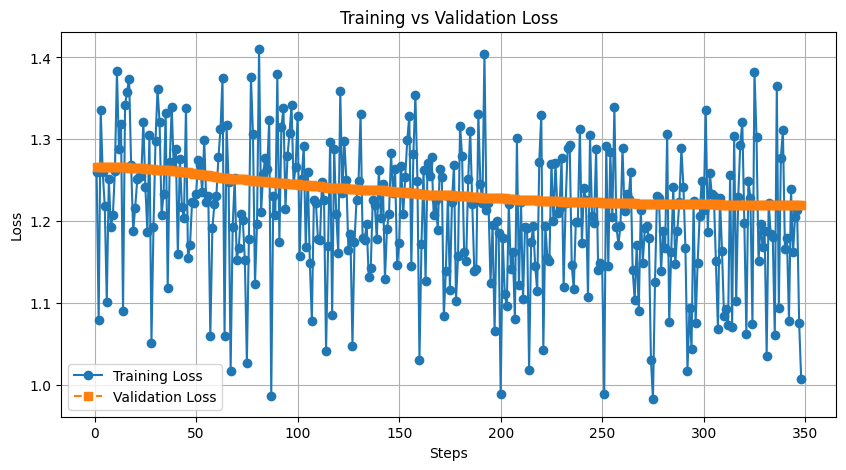

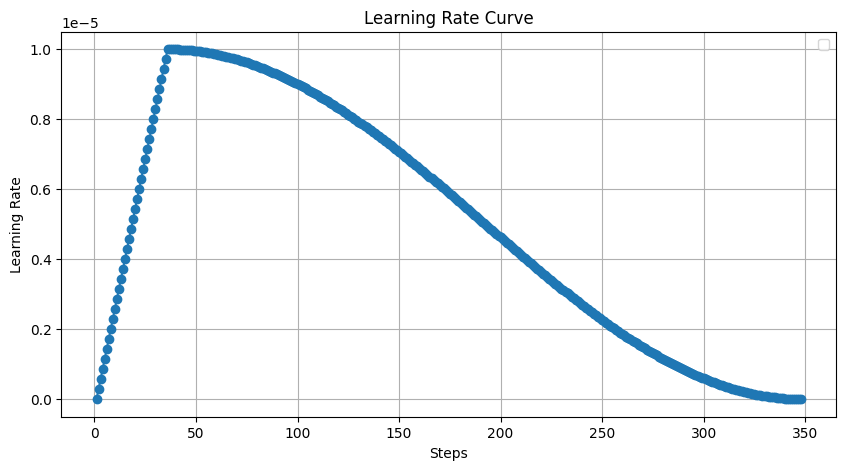

In [22]:
from utils import save_log_history

save_log_history(trainer)

In [25]:
system_message = system_messages["malware"]
user_input = format_validation_example_for_inference(dataset["eval"]["text"][50])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=1000,
          temperature=0.7,
          top_p=0.8,
          top_k=20,
          min_p=0.,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

<think>

</think>

{"objects": [{"id": null, "type":"malware","name":"Nitrogen","is_family"):false},{"id":null, "typelmalware", "name":"BlackCat\/ALPHY", "is-family":false}]}


In [24]:
!cp -r Qwen3-14B-Malware-Expert-r64-a128-nRO-2nd-run /mnt/data/training-outputs/ 
!cp -r log_history/ /mnt/data/training-outputs/Qwen3-14B-Malware-Expert-r64-a128-nRO-2nd-run/